In [41]:
import sqlite3
import pandas as pd

# create a connection with the databases
takeaway_conn = sqlite3.connect('../data/takeaway.db')

deliveroo_conn = sqlite3.connect("../data/deliveroo.db")


In [ ]:
# read data from SQL to pandas dataframe
data = pd.read_sql_query('SELECT * from categories;', takeaway_conn)

# show top 5 rows
data.head()

In [ ]:
# list tables and save them in a variable
tables_df = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';",
    takeaway_conn
)

tables = tables_df["name"].tolist()
tables


['sqlite_sequence',
 'locations',
 'restaurants',
 'locations_to_restaurants',
 'menuItems',
 'categories',
 'categories_restaurants']

In [ ]:
# SCHEMA understanding

for table in tables:
    print(table)
    display(pd.read_sql(f"PRAGMA table_info({table});", takeaway_conn))

sqlite_sequence


,cid,name,type,notnull,dflt_value,pk
0,0,name,,0,None,0
1,1,seq,,0,None,0


locations


,cid,name,type,notnull,dflt_value,pk
0,0,ID,INTEGER,0,None,1
1,1,postalCode,INTEGER,0,None,0
2,2,latitude,NUMBER,0,None,0
3,3,longitude,NUMBER,0,None,0
4,4,city,,0,None,0
5,5,name,,0,None,0


restaurants


,cid,name,type,notnull,dflt_value,pk
0,0,primarySlug,TEXT,0,None,1
1,1,restaurant_id,,0,None,0
2,2,name,TEXT,0,None,0
3,3,address,TEXT,0,None,0
4,4,city,TEXT,0,None,0
5,5,supportsDelivery,TEXT,0,None,0
6,6,supportsPickup,,0,None,0
7,7,paymentMethods,TEXT,0,None,0
8,8,ratings,NUMBER,0,None,0
9,9,ratingsNumber,INTEGER,0,None,0


locations_to_restaurants


,cid,name,type,notnull,dflt_value,pk
0,0,restaurant_id,,0,None,0
1,1,location_id,INTEGER,0,None,0


menuItems


,cid,name,type,notnull,dflt_value,pk
0,0,primarySlug,,0,None,1
1,1,id,,0,None,2
2,2,name,TEXT,0,None,0
3,3,description,TEXT,0,None,0
4,4,price,,0,None,0
5,5,alcoholContent,,0,None,0
6,6,caffeineContent,,0,None,0


categories


,cid,name,type,notnull,dflt_value,pk
0,0,id,,0,None,0
1,1,restaurant_id,,0,None,0
2,2,name,,0,None,0
3,3,item_id,,0,None,0


categories_restaurants


,cid,name,type,notnull,dflt_value,pk
0,0,category_id,,0,None,1
1,1,restaurant_id,,0,None,2


## 1. Price distribution of menu items
How are menu item prices spread across all items? What is the typical price?
Are there outliers (very expensive items)?
Is the price spread narrow or wide?

In [ ]:
price_df = pd.read_sql(
    """
    SELECT
        ID AS menu_item_id,
        name AS item_name,
        price
    FROM menuItems
    WHERE price IS NOT NULL
    """,
    takeaway_conn
)

In [6]:
# Summary statistics
price_df.info()
price_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403013 entries, 0 to 403012
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   menu_item_id  403013 non-null  object 
 1   item_name     403013 non-null  object 
 2   price         403013 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.2+ MB


,price
count,403013.000000
mean,9.973233
std,8.384140
min,0.000000
25%,4.000000
50%,9.000000
75%,13.950000
max,150.000000


In [7]:
# IQR
q1 = price_df["price"].quantile(0.25)
q3 = price_df["price"].quantile(0.75)
iqr = q3 - q1

q1, q3, iqr


(np.float64(4.0), np.float64(13.95), np.float64(9.95))

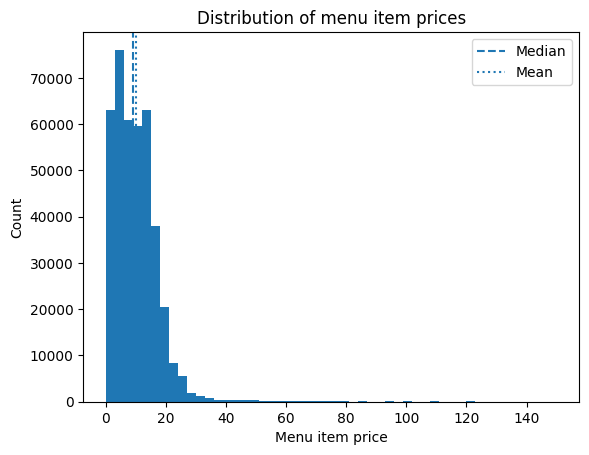

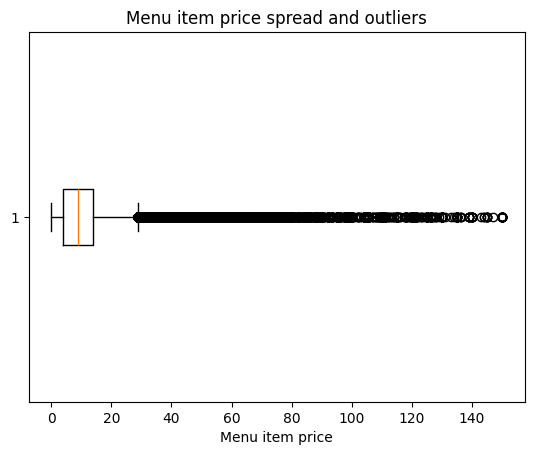

In [8]:
# Price distribution histograms
import matplotlib.pyplot as plt

# histogram 2
plt.figure()
plt.hist(price_df["price"], bins=50)
plt.axvline(price_df["price"].median(), linestyle="--", label="Median")
plt.axvline(price_df["price"].mean(), linestyle=":", label="Mean")
plt.xlabel("Menu item price")
plt.ylabel("Count")
plt.title("Distribution of menu item prices")
plt.legend()
plt.show()

# boxplot
plt.figure()
plt.boxplot(price_df["price"], vert=False)
plt.xlabel("Menu item price")
plt.title("Menu item price spread and outliers")
plt.show()



In [9]:
price_df["price"].quantile([0.9, 0.95, 0.99])


0.90    18.0
0.95    21.0
0.99    35.0
Name: price, dtype: float64

### Conclusion for question 1: price distribution: 
Menu item prices are strongly right-skewed, with the majority of items priced between €5 and €20.
The median price lies below the mean, indicating that a small number of high-priced premium items significantly increase the average price.
This suggests that while most menu offerings are affordable, restaurants also include a limited number of expensive items that extend the upper tail of the price distribution.

-From the histogram:    
Shape: The distribution has a long tail to the right.   
Most bars are concentrated on the left.   
A few values stretch far to the right (up to ~150)
👉 This is a classic right-skewed (positively skewed) distribution
     
-Where are “most items” priced?
Looking at the bar density:
The highest concentration is roughly between:
€5 and €20
After ~€25, the frequency drops sharply
Above ~€40, prices are rare (outliers)

-Most menu items are priced between €5 and €20

## 2. Distribution of restaurants per location (used Deliveroo Database)
Number of restaurants available in each delivery location.

In [3]:
restaurants_by_postal = pd.read_sql(
    """
    SELECT
        postal_code,
        COUNT(*) AS restaurant_count
    FROM restaurants
    WHERE postal_code IS NOT NULL
    GROUP BY postal_code
    ORDER BY restaurant_count DESC
    """,
    deliveroo_conn
)

len(restaurants_by_postal)

90

<Axes: title={'center': 'Top 15 Postal Codes by Number of Restaurants'}, xlabel='postal_code'>

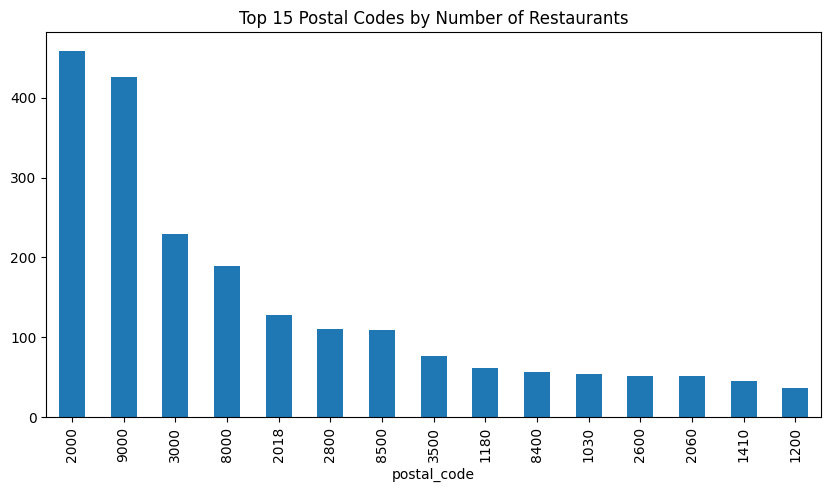

In [5]:
# Top 15 postal code

top_15 = restaurants_by_postal.head(15)

top_15.plot(
    kind="bar",
    x="postal_code",
    y="restaurant_count",
    figsize=(10, 5),
    legend=False,
    title="Top 15 Postal Codes by Number of Restaurants"
)


In [9]:
# How many postal codes have very few restaurants?
low_coverage_areas = restaurants_by_postal[
    restaurants_by_postal["restaurant_count"] <= 2
]

low_coverage_areas_count = len(low_coverage_areas)

low_coverage_areas_count

low_coverage_areas.sort_values("restaurant_count").head(30)


,postal_code,restaurant_count
73,2360,1
87,1060,1
86,1081,1
85,1210,1
84,1330,1
83,1700,1
82,1702,1
81,1830,1
80,1850,1
79,1930,1


In [13]:
# Percentage concentration in top postal codes
restaurants_share_by_postal = pd.read_sql(
    """
    SELECT
        postal_code,
        COUNT(*) * 1.0 / (
            SELECT COUNT(*)
            FROM restaurants
            WHERE postal_code IS NOT NULL
        ) AS share_of_total
    FROM restaurants
    WHERE postal_code IS NOT NULL
    GROUP BY postal_code
    ORDER BY share_of_total DESC
    LIMIT 10
    """,
    deliveroo_conn
)

# convert to percentages
restaurants_share_by_postal["share_percent"] = (
    restaurants_share_by_postal["share_of_total"] * 100
)

restaurants_share_by_postal



,postal_code,share_of_total,share_percent
0,2000,0.168999,16.899853
1,9000,0.156848,15.684831
2,3000,0.084315,8.431517
3,8000,0.069588,6.958763
4,2018,0.047128,4.712813
5,2800,0.040501,4.050074
6,8500,0.040133,4.013255
7,3500,0.028351,2.835052
8,1180,0.022459,2.245950
9,8400,0.020987,2.098675


<Axes: title={'center': 'Top 10 Postal Codes by Share of Restaurants'}, xlabel='postal_code'>

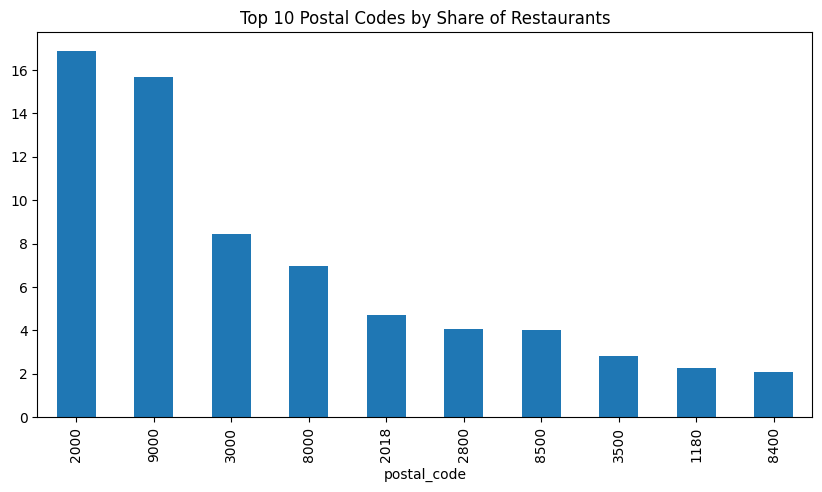

In [12]:
# visualization of restaurant shares by postal
restaurants_share_by_postal.head(10).plot(
    kind="bar",
    x="postal_code",
    y="share_percent",
    figsize=(10, 5),
    legend=False,
    title="Top 10 Postal Codes by Share of Restaurants"
)


The relative concentration of restaurants per postal code was computed as the share of total restaurants. This highlights geographic concentration and reveals that a small number of postal codes account for a disproportionately large share of restaurant supply.

### Conclusion for question 2: distribution of restaurant per location
Restaurant availability on Deliveroo is highly concentrated in major urban centers such as Antwerp, Ghent, Leuven, and Bruges, with Brussels municipalities also featuring prominently.    


Antwerp dominates (2000 + 2018)
University & tourist cities rank high
Coastal and regional capitals appear
Urban density drives platform supply

Top ten from highest to lowest: Antwerp (city centre), Ghent, Leuven, Bruges, Antwerp (South Area), Mechelen, Kortrijk, Hasselt, Uccle, Oostende


## 3. Which are the top 10 pizza restaurants by rating?

In [64]:
top_pizza_restaurants_df = pd.read_sql(
    """
    SELECT
        r.primarySlug,
        r.name,
        r.ratings,
        r.ratingsNumber
    FROM restaurants r
    WHERE r.primarySlug IN (
        SELECT DISTINCT
            mi.primarySlug
        FROM menuItems mi
        WHERE LOWER(mi.name) LIKE '%pizza%'
    )
      AND r.ratings IS NOT NULL
      AND r.ratingsNumber >= 50
    ORDER BY
        r.ratings DESC,
        r.ratingsNumber DESC
    LIMIT 10;
    """,
    takeaway_conn
)

top_pizza_restaurants_df


,primarySlug,name,ratings,ratingsNumber
0,eethuis-carlos-aarschot,De Echte Eethuis Carlos,5.0,599
1,kebap-pizza-de-brug,Kebap - Pizza De Brug,5.0,312
2,trend-kebab-pizzeria,Trend Kebab & Pizzeria,5.0,165
3,pizza-minute-schaerbeek,Pizza Minute,4.9,2833
4,pizza-heat-wetteren,Pizza Heat,4.9,1786
5,pitza-service-sint-niklaas,Pitza Service,4.9,1315
6,pizza-time-evergem,Pizza Time Evergem,4.9,1148
7,baskent-ohcange,Baskent Meerhout,4.9,879
8,pitta-seker-aalst,Pitta Seker,4.9,857
9,de-notenboom,De Notenboom,4.9,706


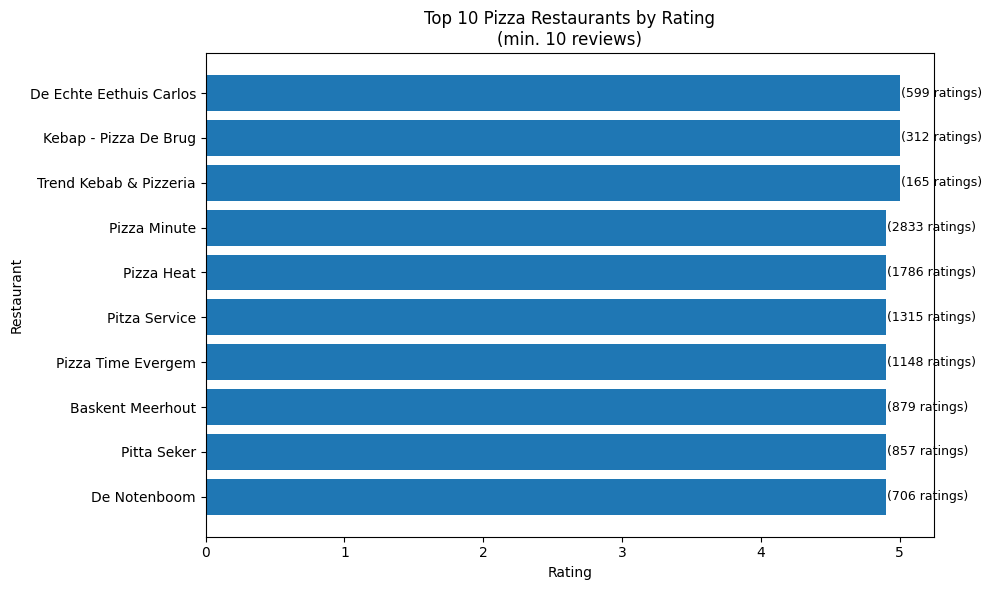

In [65]:
plot_df = top_pizza_restaurants_df.sort_values(
    by=["ratings", "ratingsNumber"],
    ascending=True
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(
    plot_df["name"],
    plot_df["ratings"]
)

for i, (_, row) in enumerate(plot_df.iterrows()):
    plt.text(
        row["ratings"] + 0.01,
        i,
        f"({int(row['ratingsNumber'])} ratings)",
        va="center",
        fontsize=9
    )

plt.xlabel("Rating")
plt.ylabel("Restaurant")
plt.title("Top 10 Pizza Restaurants by Rating\n(min. 10 reviews)")

plt.tight_layout()
plt.show()


### Average pizza price per restaurant

In [20]:
pizza_price_df = pd.read_sql(
    """
    SELECT
        r.primarySlug,
        r.name AS restaurant_name,
        r.ratings,
        r.ratingsNumber,
        AVG(m.price) AS avg_pizza_price
    FROM restaurants r
    JOIN menuItems m
        ON r.primarySlug = m.primarySlug
    WHERE LOWER(m.name) LIKE '%pizza%'
      AND m.price IS NOT NULL
      AND r.ratings IS NOT NULL
      AND r.ratingsNumber >= 10
    GROUP BY r.primarySlug
    ORDER BY r.ratings DESC, r.ratingsNumber DESC
    LIMIT 10;
    """,
    takeaway_conn
)

pizza_price_df


,primarySlug,restaurant_name,ratings,ratingsNumber,avg_pizza_price
0,eethuis-carlos-aarschot,De Echte Eethuis Carlos,5.0,599,13.026316
1,kebap-pizza-de-brug,Kebap - Pizza De Brug,5.0,312,11.115385
2,trend-kebab-pizzeria,Trend Kebab & Pizzeria,5.0,165,11.712500
3,pizza-minute-schaerbeek,Pizza Minute,4.9,2833,10.033333
4,pizza-heat-wetteren,Pizza Heat,4.9,1786,12.833333
5,pitza-service-sint-niklaas,Pitza Service,4.9,1315,15.365625
6,pizza-time-evergem,Pizza Time Evergem,4.9,1148,17.308000
7,baskent-ohcange,Baskent Meerhout,4.9,879,12.536364
8,pitta-seker-aalst,Pitta Seker,4.9,857,10.741667
9,de-notenboom,De Notenboom,4.9,706,13.000000


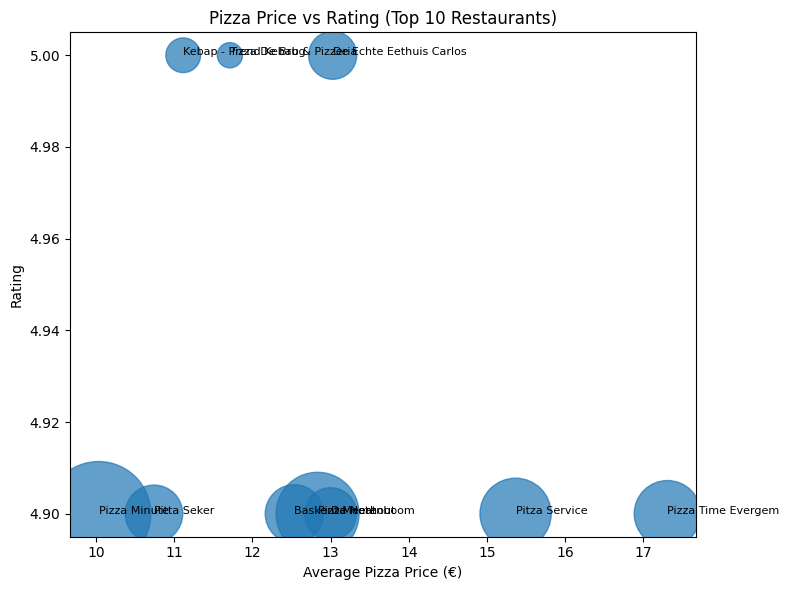

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(
    pizza_price_df["avg_pizza_price"],
    pizza_price_df["ratings"],
    s=pizza_price_df["ratingsNumber"] * 2,
    alpha=0.7
)

for _, row in pizza_price_df.iterrows():
    plt.text(
        row["avg_pizza_price"],
        row["ratings"],
        row["restaurant_name"],
        fontsize=8
    )

plt.xlabel("Average Pizza Price (€)")
plt.ylabel("Rating")
plt.title("Pizza Price vs Rating (Top 10 Restaurants)")

plt.tight_layout()
plt.show()


The scatter plot compares average pizza prices with restaurant ratings.
No clear linear relationship is observed, suggesting that higher prices do not necessarily imply higher customer satisfaction.
Some moderately priced restaurants achieve ratings comparable to premium-priced competitors, indicating potential value-for-money leaders.

## 4. Locations offering kapsalons + average price

Using the Deliveroo dataset, we mapped the availability of kapsalon by restaurant postal code.
For each postal code, we calculated the number of restaurants offering kapsalon and the average price of the dish.

In [25]:
kapsalon_by_postal_df = pd.read_sql(
    """
    SELECT
        r.postal_code,
        COUNT(DISTINCT r.id) AS kapsalon_restaurant_count,
        AVG(mi.price) AS avg_kapsalon_price
    FROM restaurants r
    JOIN menu_items mi
        ON r.id = mi.restaurant_id
    WHERE r.postal_code IS NOT NULL
      AND mi.price IS NOT NULL
      AND (
          LOWER(mi.name) LIKE '%kapsalon%'
          OR LOWER(mi.description) LIKE '%kapsalon%'
      )
    GROUP BY r.postal_code
    ORDER BY kapsalon_restaurant_count DESC
    """,
    deliveroo_conn
)

kapsalon_by_postal_df.head()


,postal_code,kapsalon_restaurant_count,avg_kapsalon_price
0,9000,22,9.183929
1,3000,13,7.974576
2,8000,10,9.912000
3,2060,10,8.497143
4,2000,10,8.968817


In [31]:
# Average kapsalon price
avg_kapsalon_price_df = pd.read_sql(
    """
    SELECT
        AVG(price) AS avg_kapsalon_price
    FROM menu_items
    WHERE LOWER(name) LIKE '%kapsalon%'
      AND price IS NOT NULL
    """,
    deliveroo_conn  
)

avg_kapsalon_price_df


,avg_kapsalon_price
0,9.054124


Visualization: where kapsalon is most widely available and concentration of kapsalon restaurants by area.

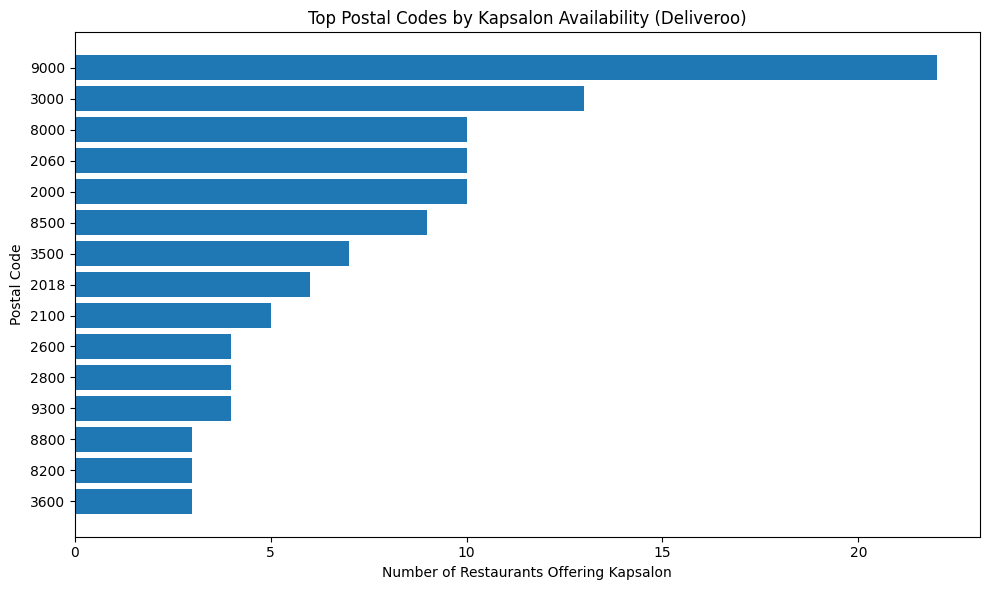

In [26]:
plot_df = (
    kapsalon_by_postal_df
    .sort_values("kapsalon_restaurant_count", ascending=False)
    .head(15)
)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(
    plot_df["postal_code"].astype(str),
    plot_df["kapsalon_restaurant_count"]
)

plt.xlabel("Number of Restaurants Offering Kapsalon")
plt.ylabel("Postal Code")
plt.title("Top Postal Codes by Kapsalon Availability (Deliveroo)")

plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


Visualization 2: Price comparison

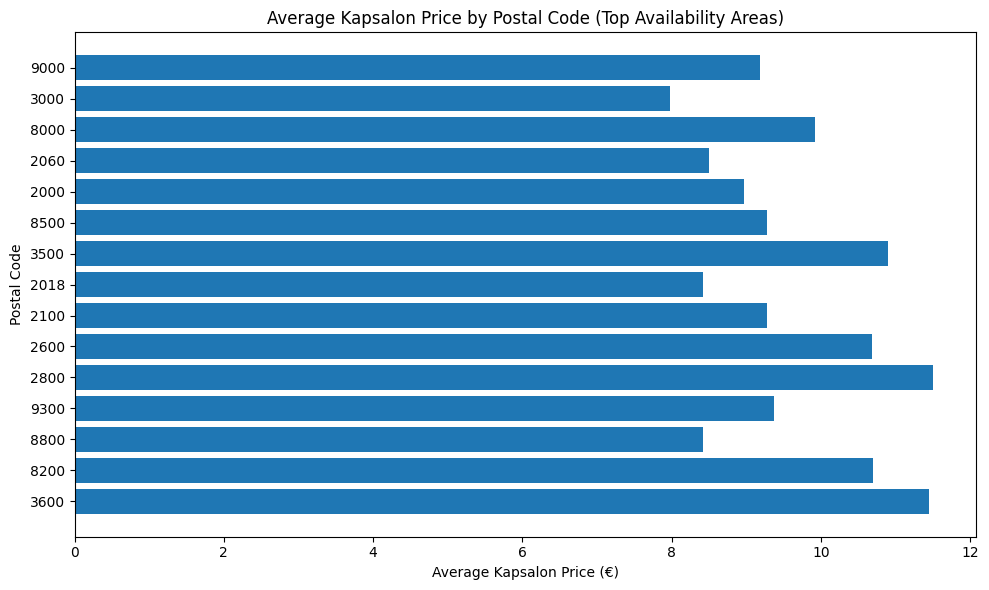

In [28]:
plt.figure(figsize=(10, 6))

plt.barh(
    plot_df["postal_code"].astype(str),
    plot_df["avg_kapsalon_price"]
)

plt.xlabel("Average Kapsalon Price (€)")
plt.ylabel("Postal Code")
plt.title("Average Kapsalon Price by Postal Code (Top Availability Areas)")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Visualization 3: combine availability vs price.    

High availability + low price → competitive areas.     

Low availability + high price → underserved / premium areas

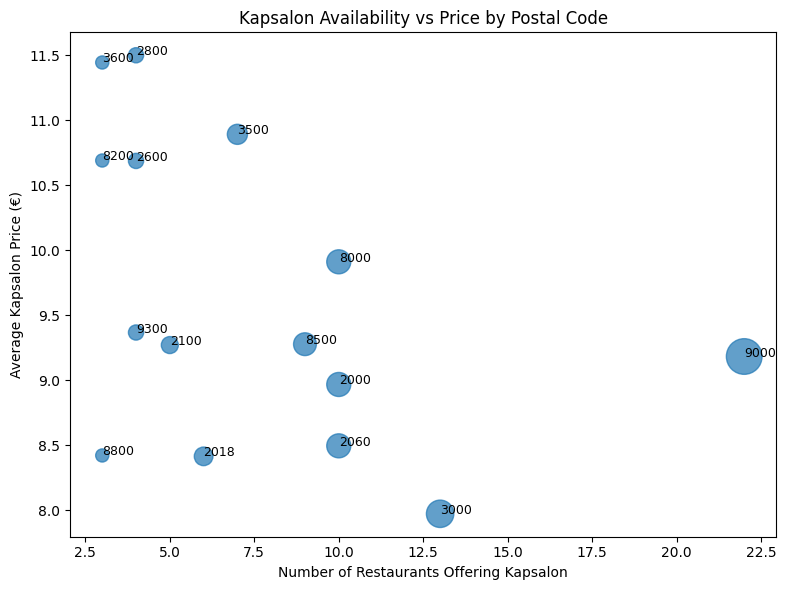

In [27]:
plt.figure(figsize=(8, 6))

plt.scatter(
    plot_df["kapsalon_restaurant_count"],
    plot_df["avg_kapsalon_price"],
    s=plot_df["kapsalon_restaurant_count"] * 30,
    alpha=0.7
)

for _, row in plot_df.iterrows():
    plt.text(
        row["kapsalon_restaurant_count"],
        row["avg_kapsalon_price"],
        str(row["postal_code"]),
        fontsize=9
    )

plt.xlabel("Number of Restaurants Offering Kapsalon")
plt.ylabel("Average Kapsalon Price (€)")
plt.title("Kapsalon Availability vs Price by Postal Code")

plt.tight_layout()
plt.show()


Using the Deliveroo dataset, we analyzed kapsalon availability by restaurant postal code.
The results show strong geographic concentration, with certain postal codes hosting significantly more kapsalon-serving restaurants.
Average prices vary moderately across areas, suggesting local competition effects rather than uniform pricing.

## 5. Which restaurants have the best price-to-rating ratio?     

A restaurant is good value if it has high rating and low average price.    
So we define a value score as:         
rating/average menu item price.  
Higher rating-> better
Lower price -> better
Higher ration: better value for money

In [33]:
best_value_restaurants_df = pd.read_sql(
    """
    SELECT
        r.primarySlug,
        r.name AS restaurant_name,
        r.city,
        r.ratings AS rating,
        r.ratingsNumber AS rating_count,
        AVG(m.price) AS avg_price,
        r.ratings / AVG(m.price) AS value_score
    FROM restaurants r
    JOIN menuItems m
        ON r.primarySlug = m.primarySlug
    WHERE
        r.ratings IS NOT NULL
        AND m.price IS NOT NULL
        AND r.ratingsNumber >= 10
        AND r.city IS NOT NULL
    GROUP BY
        r.primarySlug,
        r.name,
        r.city,
        r.ratings,
        r.ratingsNumber
    ORDER BY value_score DESC
    LIMIT 15
    """,
    takeaway_conn
)

best_value_restaurants_df


,primarySlug,restaurant_name,city,rating,rating_count,avg_price,value_score
0,el-bocadillos,El Bocadillos,Bruxelles,4.2,307,2.000000,2.100000
1,boulangerie-salam,Boulangerie Salam,Molenbeek-Saint-Jean,4.1,21,2.039535,2.010262
2,bazi-boulangerie,Bazi Boulangerie,Anderlecht,4.3,10,2.335294,1.841310
3,amigos,Frituur Amigos,Wilrijk,4.3,1172,2.411765,1.782927
4,frituur-t-krokantje,Frituur 't Krokantje,Sint-Gillis-Waas,4.9,19,2.777778,1.764000
5,quetacos,QueTacos,Maasmechelen,5.0,157,2.857143,1.750000
6,frituur-opt-hoekske,Frituur op't Hoekske,Vilvoorde,5.0,14,2.861000,1.747641
7,frituur-4-you,Frituur 4 You,Vilvorde,4.7,220,2.690471,1.746906
8,say-pasta,Say Pasta,Antwerpen,4.6,59,2.712609,1.695785
9,streettacos,Street'Tacos,Waregem,3.9,47,2.382353,1.637037


To identify restaurants offering the best value, we computed a price-to-rating ratio by dividing the restaurant rating by the average menu item price.
Only restaurants with at least 10 ratings were included to ensure reliability.


### Horizontal bar chart of “value score” (rating / avg price)

Restaurants at the top achieve high customer ratings while maintaining relatively low average prices, indicating strong value for money.

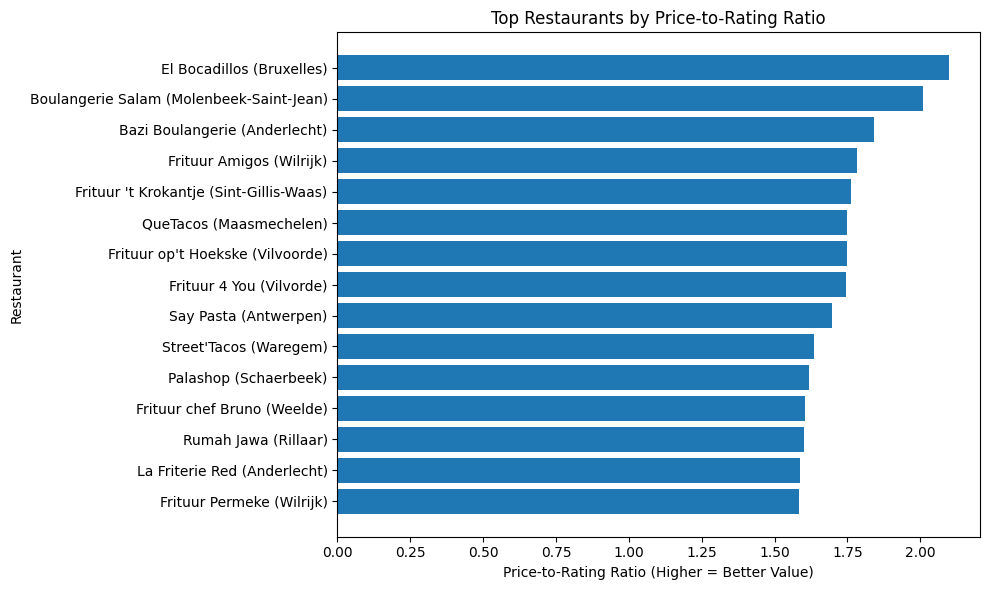

In [34]:
# label combining name + city

best_value_restaurants_df["restaurant_label"] = (
    best_value_restaurants_df["restaurant_name"]
    + " (" + best_value_restaurants_df["city"] + ")"
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(
    best_value_restaurants_df["restaurant_label"],
    best_value_restaurants_df["value_score"]
)

plt.xlabel("Price-to-Rating Ratio (Higher = Better Value)")
plt.ylabel("Restaurant")
plt.title("Top Restaurants by Price-to-Rating Ratio")

plt.gca().invert_yaxis()  # Best on top
plt.tight_layout()

plt.show()


## 6. Where are the delivery ‘dead zones’—areas with minimal restaurant coverage?

In [38]:
delivery_dead_zones_df = pd.read_sql(
    """
    SELECT 
        l.ID,
        l.name,
        l.postalCode,
        COUNT(lr.restaurant_id) AS num_restaurants
    FROM locations l
    LEFT JOIN locations_to_restaurants lr
        ON l.ID = lr.location_id
    WHERE l.postalCode != 0          
      AND l.postalCode IS NOT NULL  
    GROUP BY l.ID, l.name, l.postalCode
    ORDER BY num_restaurants ASC;
    """,
    takeaway_conn
)

delivery_dead_zones_df



,ID,name,postalCode,num_restaurants
0,86,0,8691,0
1,393,Sint-Eligiuskerk,8193,0
2,1014,Sint-Petruskerk,8691,0
3,1055,Sint-Jan-Onthoofdingkerk,8691,0
4,1062,Sint-Mildredakerk,8691,0
...,...,...,...,...
2499,2175,Heilige Familie en Sint-Corneliuskerk,2140,546
2500,247,Onze-Lieve-Vrouw-ter-Sneeuwkerk,2140,547
2501,1096,Basiliek van het Heilig Hart,2600,547
2502,731,Sint-Annakerk,2140,552


In [39]:
delivery_dead_zones2_df = pd.read_sql(
    """
    SELECT 
        l.postalCode,
        COUNT(DISTINCT l.ID) AS num_locations,         -- number of locations in this postal code
        COUNT(DISTINCT lr.restaurant_id) AS num_restaurants -- total restaurants delivering to this postal code
    FROM locations l
    LEFT JOIN locations_to_restaurants lr
        ON l.ID = lr.location_id
    WHERE l.postalCode != 0
      AND l.postalCode IS NOT NULL
    GROUP BY l.postalCode
    ORDER BY num_restaurants ASC       -- dead zones first
    LIMIT 10                          -- top 10 dead zones
    """,
    takeaway_conn
)

delivery_dead_zones2_df

,postalCode,num_locations,num_restaurants
0,8193,1,0
1,8690,3,0
2,8691,7,0
3,8640,4,1
4,8647,5,1
5,8972,4,1
6,8978,2,1
7,9988,2,1
8,8951,1,2
9,8958,2,2


In [47]:
import folium 

# List of dead zone postal codes
dead_postal_codes = [8193, 8690, 8691, 8640, 8647, 8972, 8978, 9988, 8951, 8958]

# Load Belgian postal codes with coordinates
postal_df = pd.read_csv("../data/belgian-cities-geocoded.csv")  # contains 'postal','lat','lng'

# Filter only dead zones
dead_zones_df = postal_df[postal_df['postal'].isin(dead_postal_codes)]

# Create a Folium map centered on Belgium
belgium_map = folium.Map(location=[50.85, 4.35], zoom_start=7)  # roughly center of Belgium

# Add markers for dead zones
for _, row in dead_zones_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=8,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=f"Postal Code: {row['postal']}"
    ).add_to(belgium_map)

# Save map to HTML
belgium_map.save("belgium_dead_zones_map.html")

# To display in Jupyter Notebook directly:
belgium_map


## 7. How does the availability of vegetarian and vegan dishes vary by area?

In [55]:
veg_vegan_df = pd.read_sql(
    """
SELECT 
    l.postalCode,
    COUNT(DISTINCT l2r.restaurant_id) AS total_restaurants,
    COUNT(DISTINCT CASE WHEN LOWER(c.name) LIKE '%vegetarian%' THEN l2r.restaurant_id END) AS vegetarian_restaurants,
    COUNT(DISTINCT CASE WHEN LOWER(c.name) LIKE '%vegan%' THEN l2r.restaurant_id END) AS vegan_restaurants
FROM locations l
LEFT JOIN locations_to_restaurants l2r
    ON l.ID = l2r.location_id
LEFT JOIN categories c
    ON l2r.restaurant_id = c.restaurant_id
WHERE l.postalCode IS NOT NULL
  AND l.postalCode != 0
GROUP BY l.postalCode
ORDER BY total_restaurants DESC;
""", takeaway_conn)

# Calculate percentages
veg_vegan_df['percent_vegetarian'] = veg_vegan_df['vegetarian_restaurants'] / veg_vegan_df['total_restaurants'] * 100
veg_vegan_df['percent_vegan'] = veg_vegan_df['vegan_restaurants'] / veg_vegan_df['total_restaurants'] * 100

veg_vegan_df.head()


,postalCode,total_restaurants,vegetarian_restaurants,vegan_restaurants,percent_vegetarian,percent_vegan
0,1140,605,5,11,0.826446,1.818182
1,2600,578,26,24,4.498270,4.152249
2,2140,570,26,22,4.561404,3.859649
3,2018,566,24,23,4.240283,4.063604
4,2060,547,24,20,4.387569,3.656307


In [58]:

# Load Belgian postal code coordinates
postal_coords = pd.read_csv("../data/belgian-cities-geocoded.csv")

# Ensure same datatype
veg_vegan_df["postalCode"] = veg_vegan_df["postalCode"].astype(str)
postal_coords["postal"] = postal_coords["postal"].astype(str)

# Merge
map_df = veg_vegan_df.merge(
    postal_coords,
    left_on="postalCode",
    right_on="postal",
    how="inner"
)

map_df.head()


,postalCode,total_restaurants,vegetarian_restaurants,vegan_restaurants,percent_vegetarian,percent_vegan,postal,name,lat,lng,province
0,1140,605,5,11,0.826446,1.818182,1140,Evere,50.873935,4.400942,Vlaams-Brabant
1,2600,578,26,24,4.498270,4.152249,2600,Berchem,51.189856,4.432951,Antwerpen
2,2140,570,26,22,4.561404,3.859649,2140,Borgerhout,51.214317,4.434899,Antwerpen
3,2018,566,24,23,4.240283,4.063604,2018,Antwerpen,51.203769,4.411264,Antwerpen
4,2060,547,24,20,4.387569,3.656307,2060,Antwerpen,51.226939,4.427630,Antwerpen


In [60]:
import folium

# Create map centered on Belgium
belgium_map = folium.Map(location=[50.85, 4.35], zoom_start=7)

# Add circles for each postal code
for _, row in map_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=6,
        color=None,
        fill=True,
        fill_color="green" if row["percent_vegan"] >= 20 else "orange" if row["percent_vegan"] >= 5 else "red",
        fill_opacity=0.7,
        popup=(
            f"Postal code: {row['postalCode']}<br>"
            f"Vegan restaurants: {row['percent_vegan']:.1f}%<br>"
            f"Vegetarian restaurants: {row['percent_vegetarian']:.1f}%"
        )
    ).add_to(belgium_map)

# Save map
belgium_map.save("belgium_vegan_vegetarian_coverage.html")


## 8. Identify the World Hummus Order (WHO); top 3 hummus serving restaurants.

In [61]:
top_hummus_restaurants_df = pd.read_sql(
    """
    SELECT
        r.primarySlug,
        r.name AS restaurant_name,
        r.city,
        r.ratings AS rating,
        r.ratingsNumber AS rating_count
    FROM restaurants r
    WHERE r.primarySlug IN (
        SELECT DISTINCT m.primarySlug
        FROM menuItems m
        WHERE LOWER(m.name) LIKE '%hummus%'
    )
    AND r.ratings IS NOT NULL
    AND r.ratingsNumber >= 10
    ORDER BY
        r.ratings DESC,
        r.ratingsNumber DESC
    LIMIT 3
    """,
    takeaway_conn
)

top_hummus_restaurants_df


,primarySlug,restaurant_name,city,rating,rating_count
0,restaurant-le-royal,Restaurant le Royal,Bruxelles-Capitale,5.0,359
1,royal-donuts-bagels-maasmechelen,Royal Donuts & Bagels,Maasmechelen,5.0,94
2,the-black-horse,The Black Horse,Heist-op-den-Berg,4.9,127


### Visualization Q8: Top Three Hummus places

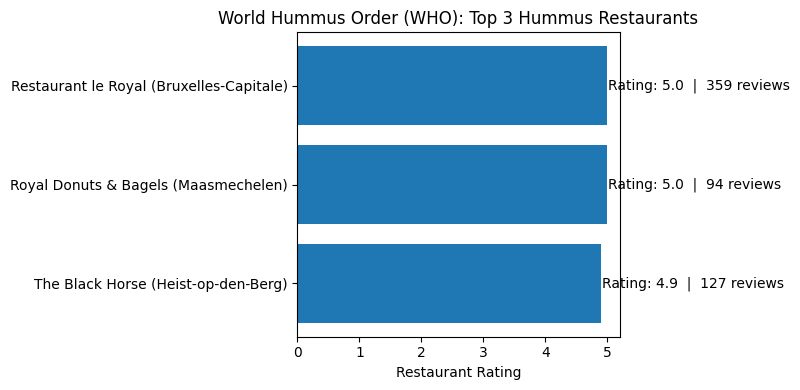

In [63]:
top_hummus_restaurants_df["label"] = (
    top_hummus_restaurants_df["restaurant_name"]
    + " (" + top_hummus_restaurants_df["city"] + ")"
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.barh(
    top_hummus_restaurants_df["label"],
    top_hummus_restaurants_df["rating"]
)

plt.xlabel("Restaurant Rating")
plt.title("World Hummus Order (WHO): Top 3 Hummus Restaurants")

# Best restaurant on top
plt.gca().invert_yaxis()

# Add annotations (rating + number of reviews)
for i, row in top_hummus_restaurants_df.iterrows():
    plt.text(
        row["rating"] + 0.02,
        i,
        f"Rating: {row['rating']}  |  {row['rating_count']} reviews",
        va="center",
        fontsize=10
    )

plt.xlim(0, 5.2)
plt.tight_layout()
plt.show()
